<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/econml/gamesecond/cm_gamesecond_X_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q econml scikit-learn
%pip show econml scikit-learn

     |████████████████████████████████| 317kB 4.8MB/s 
     |████████████████████████████████| 110.5MB 70kB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 3.8MB 46.3MB/s 
     |████████████████████████████████| 512kB 41.9MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: sparse 0.11.2 has requirement numba>=0.49, but you'll have numba 0.48.0 which is incompatible.
ERROR: econml 0.7.0 has requirement scikit-learn~=0.21.0, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
Name: econml
Version: 0.7.0
Summary: This package contains several methods for calculating Conditional Average Treatment Effects
Home-page: https://github.com/Microsoft/EconML
Author: Microsoft Corporation
Author-email: None
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorflow, statsmodels, joblib

In [7]:
%cd /content/drive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML/gamesecond
%ls

/content/drive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML/gamesecond
cm_causality.ipynb  cm_gamesecond_X_DA.ipynb


# アプリのCM配信におけるユーザの傾向スコアの分布とCATEの関係性を分析

In [8]:
import copy, os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingRegressor

from econml.drlearner import SparseLinearDRLearner
from econml.metalearners import SLearner, TLearner, DomainAdaptationLearner, XLearner
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.utilities import Summary

## データの前処理






### 分析対象のデータ読み込み

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,0,0,0,0,0,0,0,800.0,2.0,0,0,1,0,0,1,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,749.5,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,49.344942,0,0


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.414400,0.074000,0.091200,0.588700,0.111500,0.208600,40.841900,0.640300,0.647000,0.566200,0.054200,0.075900,0.012300,0.117700,0.099900,0.039900,0.033900,357.829700,3.55234,0.148000,0.144800,0.620400,0.069900,0.016900,0.42300,0.013200,0.127800,0.173300,0.052200,0.140300,0.328800,0.164400,8096.497203,2846.783400,9.433300
std,0.492643,0.261784,0.287908,0.492094,0.314766,0.406328,10.465434,0.479936,0.477927,0.495623,0.226423,0.264851,0.110227,0.322269,0.299882,0.195734,0.180981,267.408383,3.37777,0.355118,0.351917,0.485312,0.254991,0.128903,0.49406,0.114136,0.333884,0.378525,0.222441,0.347315,0.469801,0.370657,7709.497437,17973.608991,54.475214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.875270,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2502.245967,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,349.500000,2.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5944.444520,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,549.500000,4.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11154.786148,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,800.000000,20.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,49036.055042,364814.000000,765.000000


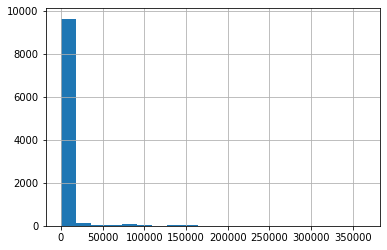

In [9]:
DATA_DIR = "../../datasets" #@param{type:'string'}
CSV_FILE = "game_cm_abtest.csv" #@param{type:'string'}

data_path = os.path.join(DATA_DIR, CSV_FILE)

read_data = pd.read_csv(data_path)
display(read_data.head())

# 欠損数及び統計量の確認
display(read_data.describe())

# アウトカムの分布を確認
display(read_data["gamesecond"].hist(bins=20))

### 列を整理

In [10]:
# 介入変数
TREATMENT_COLUMN = "cm_dummy" # @param{type:'string'}
# アウトカム
OUTCOME_COLUMN = "gamesecond" #@param{type:'string'}

# 今回使用しない列名
UNNECESSARY_COLUMNS = ['gamedummy', 'gamecount']
# 交絡因子の抽出
drop_cols = copy.deepcopy(UNNECESSARY_COLUMNS)
drop_cols.extend([TREATMENT_COLUMN, OUTCOME_COLUMN])
COVARIATE_COLUMNS = read_data.drop(columns=drop_cols).columns

print('介入変数:{t_col}, アウトカム:{o_col}, 交絡因子:{f_cols}'.format(t_col=TREATMENT_COLUMN, o_col=OUTCOME_COLUMN, f_cols=COVARIATE_COLUMNS))


# 使用する列名のみ抽出
data = read_data.drop(columns=UNNECESSARY_COLUMNS)
display(data.head(3))


# 介入群とコントロール群の平均値の差
result = data[data[TREATMENT_COLUMN] == 1].mean() - data[data[TREATMENT_COLUMN] == 0].mean()
print('{col}列に関する平均値の差分:{score}'.format(col=OUTCOME_COLUMN, score=result[OUTCOME_COLUMN]))

介入変数:cm_dummy, アウトカム:gamesecond, 交絡因子:Index(['area_kanto', 'area_keihan', 'area_tokai', 'area_keihanshin', 'age',
       'sex', 'marry_dummy', 'job_dummy1', 'job_dummy2', 'job_dummy3',
       'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7', 'job_dummy8',
       'inc', 'pmoney', 'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3',
       'fam_str_dummy4', 'fam_str_dummy5', 'child_dummy', 'T', 'F1', 'F2',
       'F3', 'M1', 'M2', 'M3', 'TVwatch_day'],
      dtype='object')


,cm_dummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond
0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0
1,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0
2,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0


gamesecond列に関する平均値の差分:-629.6405765396544


単純に平均値を比較してしまうと、CM広告がゲームプレイ回数を減少させる結果となる

### 訓練データとテストデータに分割

In [11]:
SEED = 7 # @param{type:'number'}

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=SEED)
print("分割前のデータサイズ:{size}".format(size=data.shape))
print("訓練データサイズ:{size}".format(size=train_data.shape))
print("訓練データサイズ:{size}".format(size=test_data.shape))

print("---訓練データ内のアウトカムの統計量---\n{num}\n".format(num=train_data[OUTCOME_COLUMN].describe()))
print("---テストデータ内のアウトカムの統計量---\n{num}\n".format(num=test_data[OUTCOME_COLUMN].describe()))

分割前のデータサイズ:(10000, 33)
訓練データサイズ:(8000, 33)
訓練データサイズ:(2000, 33)
---訓練データ内のアウトカムの統計量---
count      8000.000000
mean       2962.627250
std       18693.136545
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      364814.000000
Name: gamesecond, dtype: float64

---テストデータ内のアウトカムの統計量---
count      2000.000000
mean       2383.408000
std       14743.580547
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      223095.000000
Name: gamesecond, dtype: float64



## 2. 因果効果を推論するモデルの構築

### SparseDRLearner

In [12]:
%%time
def SparseDRLearner_fn(model_propensity=None, model_regression=None, max_iter=1000, cv=2, alpha='auto', seed=None):
    '''SparseDRLearnerを定義'''
    model = SparseLinearDRLearner(model_propensity=model_propensity, model_regression=model_regression,
                                  max_iter=max_iter, n_splits=cv, alpha=alpha,
                                  random_state=seed)
    return model


# 傾向スコアモデル(分類モデル)の定義
model_propensity = GradientBoostingClassifier(random_state=SEED)
# アウトカム予測の回帰モデルを定義
model_regression = HistGradientBoostingRegressor(max_iter=1000, random_state=SEED)
# クロスバリデーション数の設定
CV = 5
# 因果推論モデルの定義
sparse_dr_learner = SparseDRLearner_fn(model_propensity=model_propensity,
                                       model_regression=model_regression,
                                       cv=CV,
                                       seed=SEED)

display(sparse_dr_learner)

# 因果推論モデルの学習
sparse_dr_learner.fit(Y=train_data[OUTCOME_COLUMN].values,
                      T=train_data[TREATMENT_COLUMN].values,
                      X=train_data.drop(columns=[OUTCOME_COLUMN, TREATMENT_COLUMN]).values,
                      inference='debiasedlasso')

CPU times: user 1min 19s, sys: 2.53 s, total: 1min 21s
Wall time: 41.9 s


##### モデルの評価

In [13]:
%%time
def calc_score_model_propensity(learner, train_X_values, train_y_values, test_X_values, test_y_values):
    """
    propensityモデルのscore関数を使い、訓練精度とテスト精度を算出
    """
    train_score = learner.models_propensity[0].score(X=train_X_values, y=train_y_values)
    test_score = learner.models_propensity[0].score(X=test_X_values, y=test_y_values)
    return train_score, test_score


train_score, test_score = calc_score_model_propensity(sparse_dr_learner, 
                                                      train_data[COVARIATE_COLUMNS].values, train_data[TREATMENT_COLUMN].values,
                                                      test_data[COVARIATE_COLUMNS].values, test_data[TREATMENT_COLUMN].values)
print("傾向スコアモデルの訓練精度:{}".format(train_score))
print("傾向スコアモデルのテスト精度:{}".format(test_score))

傾向スコアモデルの訓練精度:0.79775
傾向スコアモデルのテスト精度:0.7685
CPU times: user 71.9 ms, sys: 44 ms, total: 116 ms
Wall time: 65.8 ms


In [14]:
%%time
# 訓練/テストデータに対するMSEを算出
train_score = sparse_dr_learner.score(Y=train_data[OUTCOME_COLUMN].values, 
                                      T=train_data[TREATMENT_COLUMN].values,
                                      X=train_data.drop(columns=[OUTCOME_COLUMN, TREATMENT_COLUMN]).values)
test_score = sparse_dr_learner.score(Y=test_data[OUTCOME_COLUMN].values, 
                                      T=test_data[TREATMENT_COLUMN].values,
                                      X=test_data.drop(columns=[OUTCOME_COLUMN, TREATMENT_COLUMN]).values)
print('訓練データのMSE : {}'.format(train_score))
print('テストデータのMSE : {}'.format(test_score))

訓練データのMSE : 48426895.285569295
テストデータのMSE : 41331403.61672086
CPU times: user 7.26 s, sys: 96.3 ms, total: 7.35 s
Wall time: 3.74 s


#### 推定結果

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
area_kanto,-2234.133,339.143,-6.588,0.0,-2791.974,-1676.292
area_keihan,2005.803,198.097,10.125,0.0,1679.961,2331.644
area_tokai,-1320.691,311.86,-4.235,0.0,-1833.655,-807.728
area_keihanshin,-1034.551,239.016,-4.328,0.0,-1427.697,-641.406
age,10.435,9.509,1.097,0.272,-5.206,26.077
sex,-212.494,203.007,-1.047,0.295,-546.411,121.423
marry_dummy,1057.966,204.025,5.185,0.0,722.375,1393.557
job_dummy1,-539.291,196.776,-2.741,0.006,-862.958,-215.624
job_dummy2,3043.074,433.192,7.025,0.0,2330.538,3755.611
job_dummy3,-307.926,368.131,-0.836,0.403,-913.448,297.596


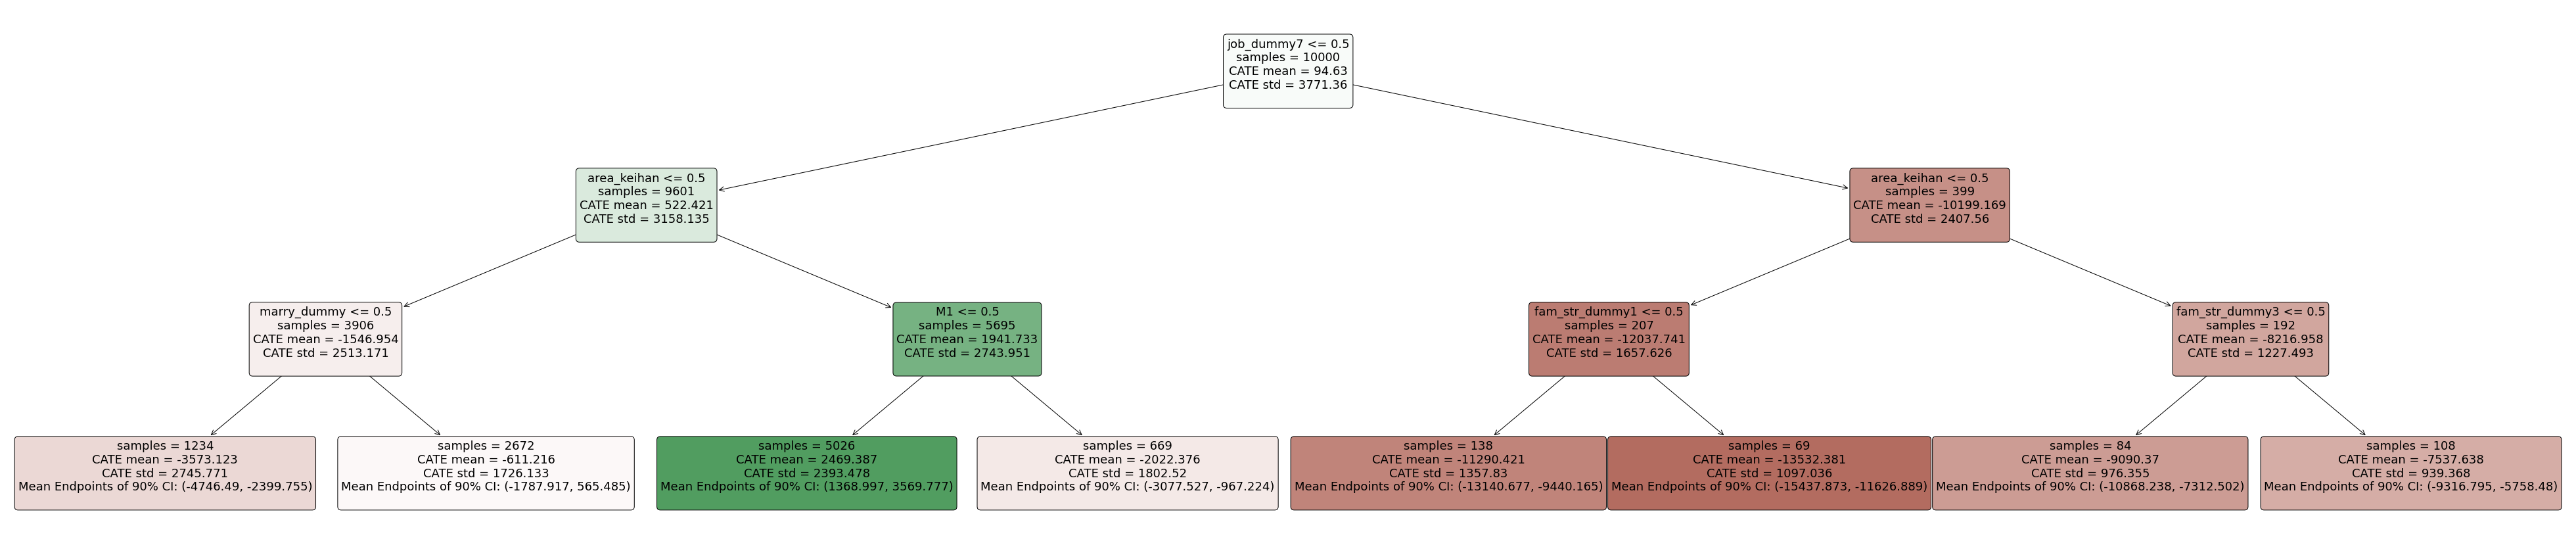

CPU times: user 2.42 s, sys: 120 ms, total: 2.54 s
Wall time: 1.41 s


In [15]:
%%time
%matplotlib inline
# 回帰係数の確認
smry = sparse_dr_learner.summary(T=1, feat_name=COVARIATE_COLUMNS)
display(smry)

# CATEの算出結果を表示
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrp.interpret(sparse_dr_learner, data[COVARIATE_COLUMNS].values)
plt.figure(figsize=(70, 15))
intrp.plot(feature_names=COVARIATE_COLUMNS)
plt.show()

### X-Learner

In [16]:
%%time
def XLearner_fn(models=None, propensity_model=None, cate_models=None):
    '''XLearnerを定義'''
    model = XLearner(models=models,
                     propensity_model=propensity_model,
                     cate_models=cate_models)
    return model


# 傾向スコアモデル(分類モデル)の定義
propensity_model = GradientBoostingClassifier(random_state=SEED)
# アウトカム予測の回帰モデルを定義
#models = HistGradientBoostingRegressor(max_iter=1000, random_state=SEED)
models = HistGradientBoostingRegressor(random_state=SEED)
# CATE予測の回帰モデルを定義
#cate_models = HistGradientBoostingRegressor(max_iter=1000, random_state=SEED)
cate_models = HistGradientBoostingRegressor(random_state=SEED)
# 因果推論モデルの定義
x_learner = XLearner_fn(models=models,
                        propensity_model=propensity_model,
                        cate_models=cate_models)

display(x_learner)

# 因果推論モデルの学習
x_learner.fit(Y=train_data[OUTCOME_COLUMN].values,
              T=train_data[TREATMENT_COLUMN].values,
              X=train_data.drop(columns=[OUTCOME_COLUMN, TREATMENT_COLUMN]).values)
              #inference='bootstrap')
                      

CPU times: user 8.14 s, sys: 161 ms, total: 8.3 s
Wall time: 4.39 s


#### モデルの評価
Learner自体の精度を測る方法は調査中

In [17]:
%%time
def calc_score_propensity_model(x_learner, train_X_values, train_y_values, test_X_values, test_y_values):
    """
    propensityモデルのscore関数を使い、訓練精度とテスト精度を算出
    INFO : MetaLearnerはpropensity_models属性を持つ
    """
    train_score = x_learner.propensity_models[0].score(X=train_X_values, y=train_y_values)
    test_score = x_learner.propensity_models[0].score(X=test_X_values, y=test_y_values)
    return train_score, test_score

train_score, test_score = calc_score_propensity_model(x_learner, 
                                                      train_data[COVARIATE_COLUMNS].values, train_data[TREATMENT_COLUMN].values,
                                                      test_data[COVARIATE_COLUMNS].values, test_data[TREATMENT_COLUMN].values)
print("傾向スコアモデルの訓練精度:{}".format(train_score))
print("傾向スコアモデルのテスト精度:{}".format(test_score))

傾向スコアモデルの訓練精度:0.7925
傾向スコアモデルのテスト精度:0.762
CPU times: user 27 ms, sys: 0 ns, total: 27 ms
Wall time: 27 ms


#### 推定結果

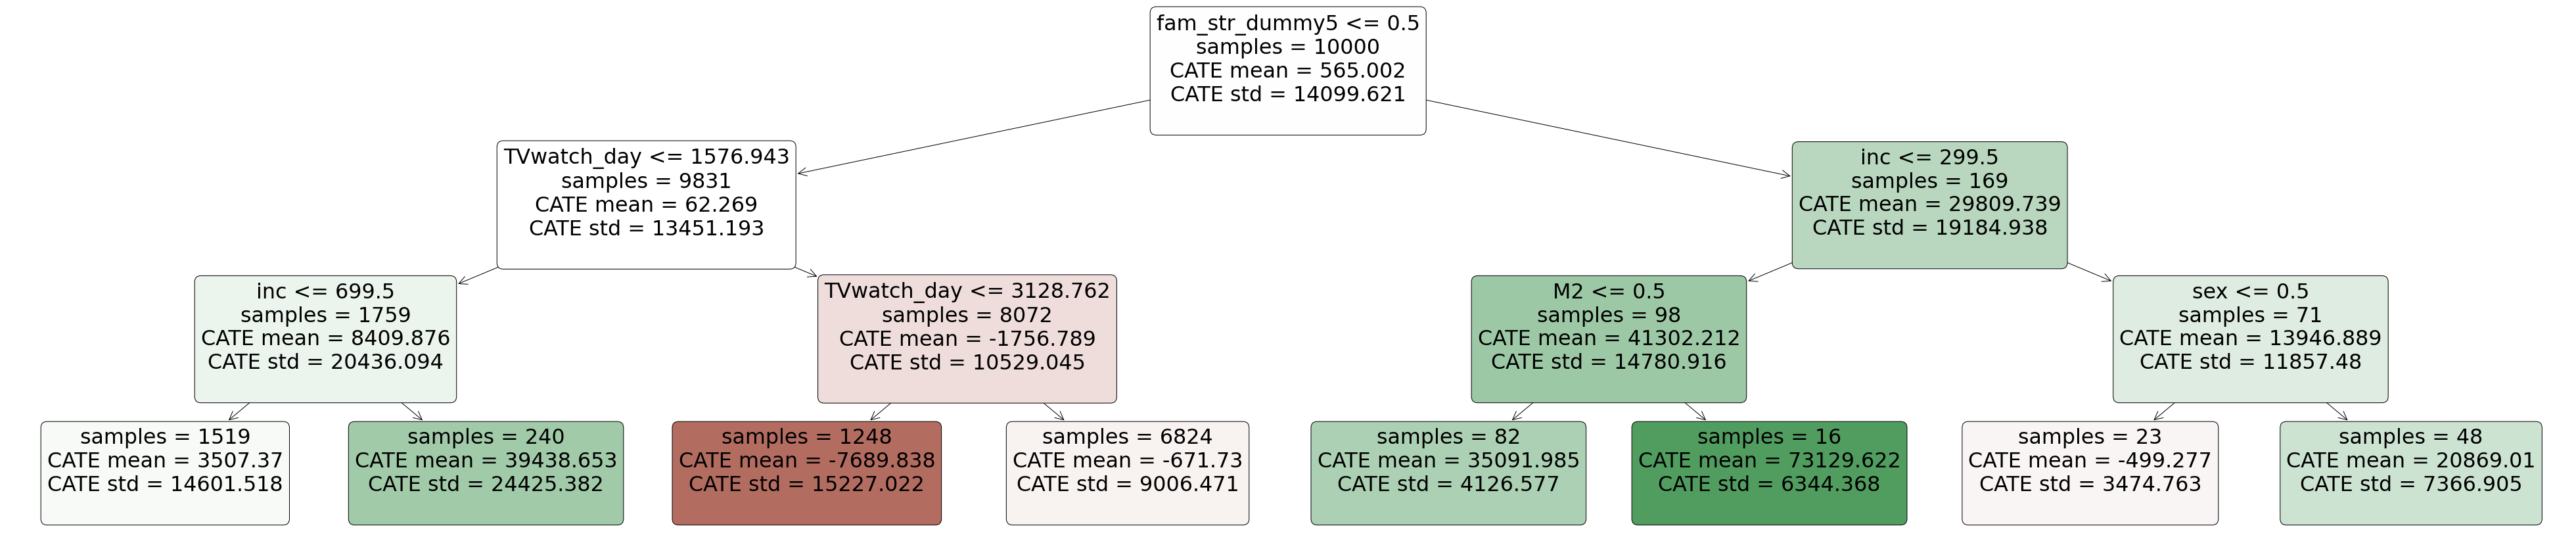

CPU times: user 2.49 s, sys: 26.7 ms, total: 2.52 s
Wall time: 1.31 s


In [18]:
%%time
%matplotlib inline
# CATEの算出結果を表示
intrp = SingleTreeCateInterpreter(include_model_uncertainty=False, max_depth=3, min_samples_leaf=10)
intrp.interpret(x_learner, data[COVARIATE_COLUMNS].values)
plt.figure(figsize=(70, 15))
intrp.plot(feature_names=COVARIATE_COLUMNS)
plt.show()